# Intro to machine learning - k-means
---


Scikit-learn has a nice set of unsupervised learning routines which can be used to explore clustering in the parameter space.

In this notebook we will use k-means, included in Scikit-learn, to demonstrate how the different rocks occupy different regions in the available parameter space.

Let's load the data using pandas:

In [1]:
import pandas as pd
import numpy as np

In [4]:
df = pd.read_csv("../data/2016_ML_contest_training_data.csv")
df.head()

,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
0,3,A1 SH,SHRIMPLIN,2793.0,77.45,0.664,9.9,11.915,4.6,1,1.000
1,3,A1 SH,SHRIMPLIN,2793.5,78.26,0.661,14.2,12.565,4.1,1,0.979
2,3,A1 SH,SHRIMPLIN,2794.0,79.05,0.658,14.8,13.050,3.6,1,0.957
3,3,A1 SH,SHRIMPLIN,2794.5,86.10,0.655,13.9,13.115,3.5,1,0.936
4,3,A1 SH,SHRIMPLIN,2795.0,74.58,0.647,13.5,13.300,3.4,1,0.915


In [5]:
df.describe()

,Facies,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
count,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000
mean,4.422030,2875.824567,66.135769,0.642719,3.559642,13.483213,3.725014,1.498453,0.520287
std,2.504243,131.006274,30.854826,0.241845,5.228948,7.698980,0.896152,0.500075,0.286792
min,1.000000,2573.500000,13.250000,-0.025949,-21.832000,0.550000,0.200000,1.000000,0.010000
25%,2.000000,2791.000000,46.918750,0.492750,1.163750,8.346750,3.100000,1.000000,0.273000
50%,4.000000,2893.500000,65.721500,0.624437,3.500000,12.150000,3.551500,1.000000,0.526000
75%,6.000000,2980.000000,79.626250,0.812735,6.432500,16.453750,4.300000,2.000000,0.767250
max,9.000000,3122.500000,361.150000,1.480000,18.600000,84.400000,8.094000,2.000000,1.000000


In [6]:
df = df.dropna()

## Calculate RHOB from DeltaPHI and PHIND

In [7]:
def rhob(phi_rhob, Rho_matrix= 2650.0, Rho_fluid=1000.0):
    """
    Rho_matrix (sandstone) : 2.65 g/cc
    Rho_matrix (Limestome): 2.71 g/cc
    Rho_matrix (Dolomite): 2.876 g/cc
    Rho_matrix (Anyhydrite): 2.977 g/cc
    Rho_matrix (Salt): 2.032 g/cc

    Rho_fluid (fresh water): 1.0 g/cc (is this more mud-like?)
    Rho_fluid (salt water): 1.1 g/cc
    see wiki.aapg.org/Density-neutron_log_porosity
    returns density porosity log """
    
    return Rho_matrix*(1 - phi_rhob) + Rho_fluid*phi_rhob


In [8]:
phi_rhob = 2*(df.PHIND/100)/(1 - df.DeltaPHI/100) - df.DeltaPHI/100
calc_RHOB = rhob(phi_rhob)
df['RHOB'] = calc_RHOB

In [9]:
df.describe()

,Facies,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS,RHOB
count,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000
mean,4.422030,2875.824567,66.135769,0.642719,3.559642,13.483213,3.725014,1.498453,0.520287,2248.911086
std,2.504243,131.006274,30.854826,0.241845,5.228948,7.698980,0.896152,0.500075,0.286792,271.200640
min,1.000000,2573.500000,13.250000,-0.025949,-21.832000,0.550000,0.200000,1.000000,0.010000,-159.040816
25%,2.000000,2791.000000,46.918750,0.492750,1.163750,8.346750,3.100000,1.000000,0.273000,2153.808486
50%,4.000000,2893.500000,65.721500,0.624437,3.500000,12.150000,3.551500,1.000000,0.526000,2315.516920
75%,6.000000,2980.000000,79.626250,0.812735,6.432500,16.453750,4.300000,2.000000,0.767250,2420.208001
max,9.000000,3122.500000,361.150000,1.480000,18.600000,84.400000,8.094000,2.000000,1.000000,2812.733802


We can define a Python dictionary to relate facies with the integer label on the `DataFrame`

In [10]:
facies_dict = {1:'sandstone', 2:'c_siltstone', 3:'f_siltstone', 4:'marine_silt_shale',
               5:'mudstone', 6:'wackentstone', 7:'dolomite', 8:'packstone', 9:'bafflestone'}

In [11]:
df["s_Facies"] = df.Facies.map(lambda x: facies_dict[x])

In [12]:
df.head()

,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS,RHOB,s_Facies
0,3,A1 SH,SHRIMPLIN,2793.0,77.45,0.664,9.9,11.915,4.6,1,1.000,2376.951554,f_siltstone
1,3,A1 SH,SHRIMPLIN,2793.5,78.26,0.661,14.2,12.565,4.1,1,0.979,2401.030769,f_siltstone
2,3,A1 SH,SHRIMPLIN,2794.0,79.05,0.658,14.8,13.050,3.6,1,0.957,2388.742254,f_siltstone
3,3,A1 SH,SHRIMPLIN,2794.5,86.10,0.655,13.9,13.115,3.5,1,0.936,2376.684495,f_siltstone
4,3,A1 SH,SHRIMPLIN,2795.0,74.58,0.647,13.5,13.300,3.4,1,0.915,2365.351156,f_siltstone


We can easily visualize the properties of each facies and how they compare using a `PairPlot`. The library `seaborn` integrates with matplotlib to make these kind of plots easily.

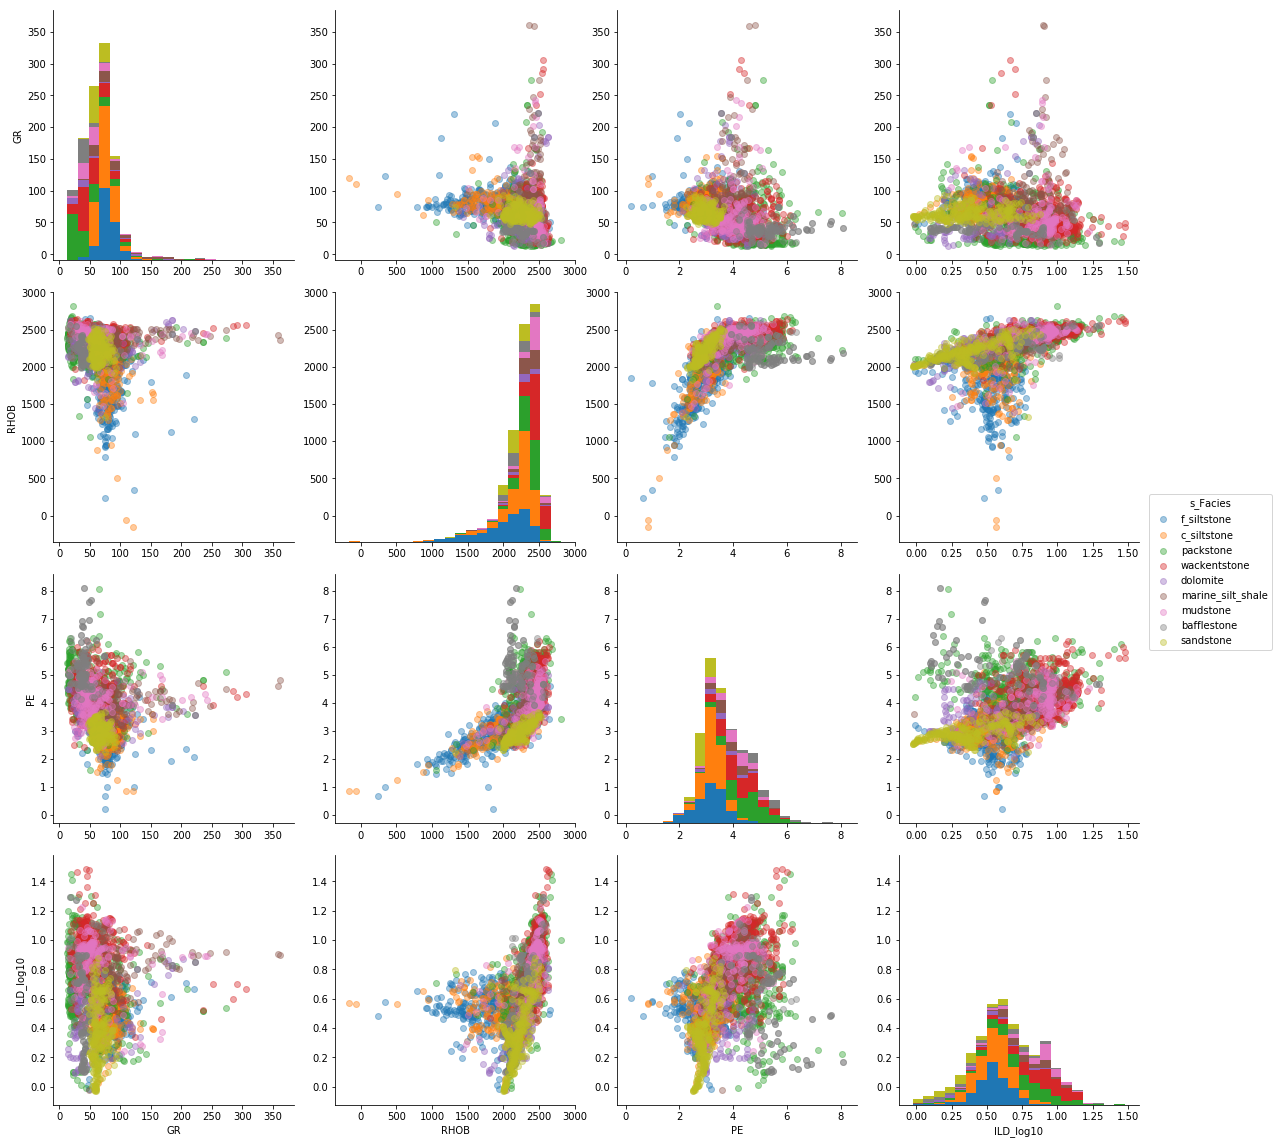

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

g = sns.PairGrid(df, hue="s_Facies", vars=['GR','RHOB','PE','ILD_log10'], size=4)

g.map_upper(plt.scatter,**dict(alpha=0.4))  
g.map_lower(plt.scatter,**dict(alpha=0.4))
g.map_diag(plt.hist,**dict(bins=20))  
g.add_legend()
g.set(alpha=0.5)

It is very clear that it's hard to separate these facies in feature space. Let's just select a couple of facies and using Pandas, select the rows in the `DataFrame` that contain information about those facies 

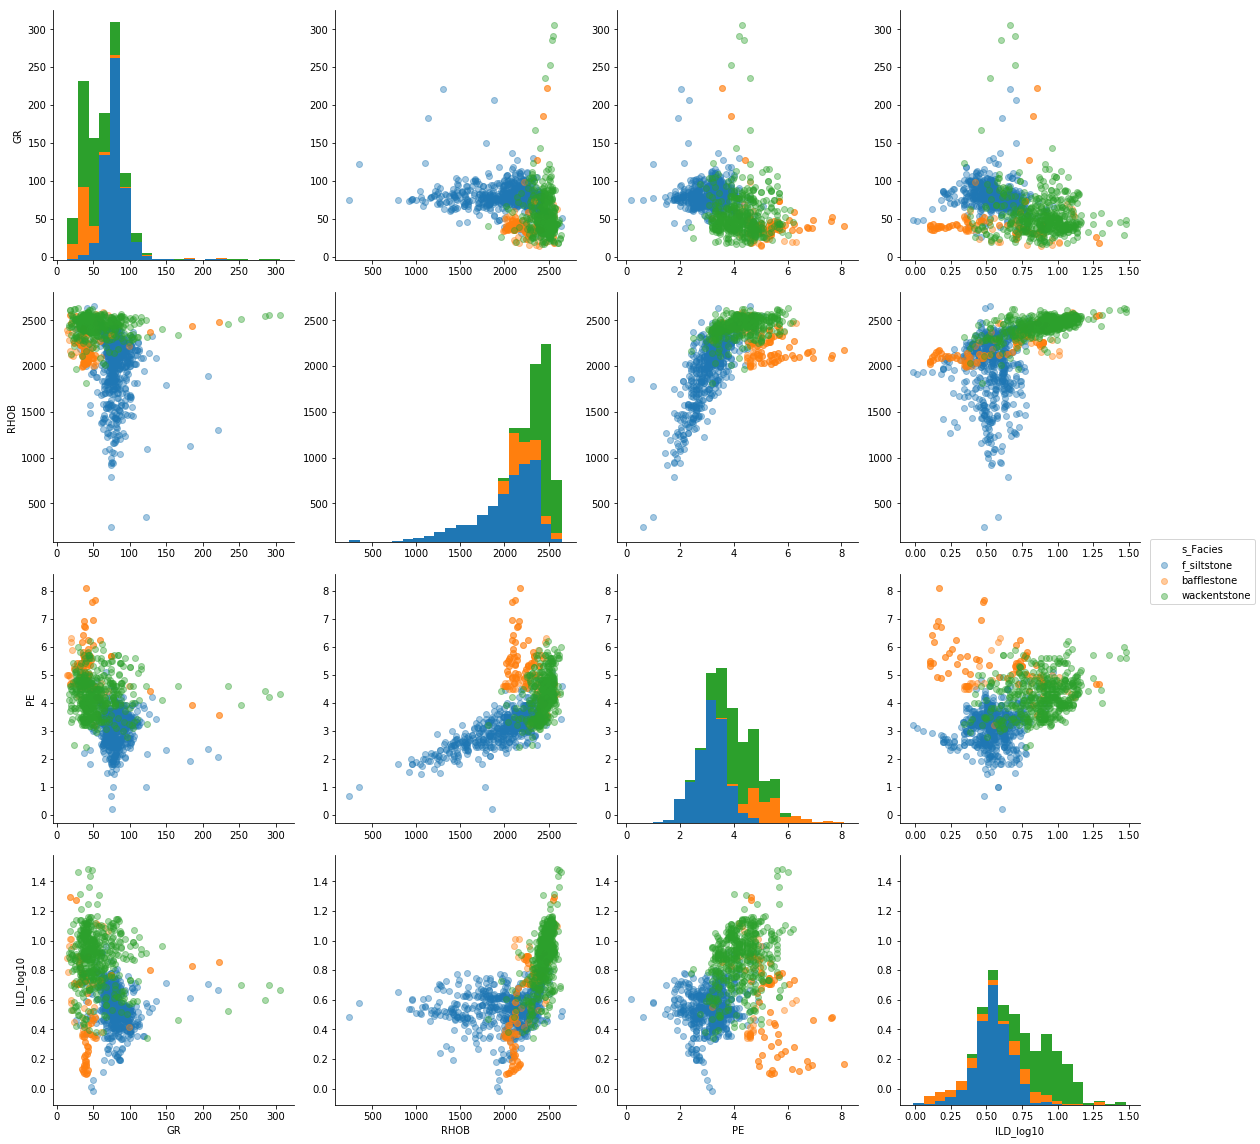

In [14]:
selected = ['f_siltstone', 'bafflestone', 'wackentstone']

dfs = pd.concat(list(map(lambda x: df[df.s_Facies == x], selected)))

g = sns.PairGrid(dfs, hue="s_Facies", vars=['GR','RHOB','PE','ILD_log10'], size=4)  
g.map_upper(plt.scatter,**dict(alpha=0.4))  
g.map_lower(plt.scatter,**dict(alpha=0.4))
g.map_diag(plt.hist,**dict(bins=20))  
g.add_legend()
g.set(alpha=0.5)

In [15]:
# Make X and y
X = dfs[['GR','ILD_log10','PE']].as_matrix()
y = dfs['Facies'].values

Use scikit-learn StandardScaler to normalize the data. Needed for k-means.

In [16]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X = scaler.fit_transform(X)

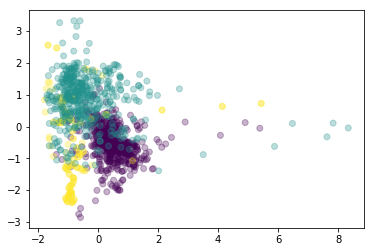

In [17]:
plt.scatter(X[:, 0], X[:, 1], c=y, alpha=0.3)

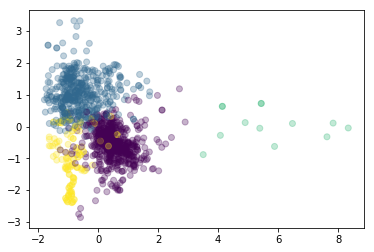

In [18]:
from sklearn.cluster import KMeans

clf = KMeans(n_clusters=4, random_state=1).fit(X)
y_pred = clf.predict(X)

plt.scatter(X[:, 0], X[:, 1], c=y_pred, alpha=0.3)

In [19]:
clf.inertia_

1336.4944748694022

<hr />

<p style="color:gray">©2017 Agile Geoscience. Licensed CC-BY.</p>